# Image Classification with a Convolutional Neural Network

Following the *Image Classification* tenserflow tutorial.

With my own notes in the markdown and code comments.

### Load Libraries and Dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL #Python Imaging Library
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#get dataset
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 6s 0us/step


The directory is structured as follows:
```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```



In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


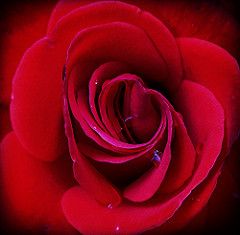

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[4]))

In [ ]:
#load images off disk
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#80-20 validation split (training subset)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
#80-20 validation split (validation subset)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Visualization

In [ ]:
#get class names that the images will be put into
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


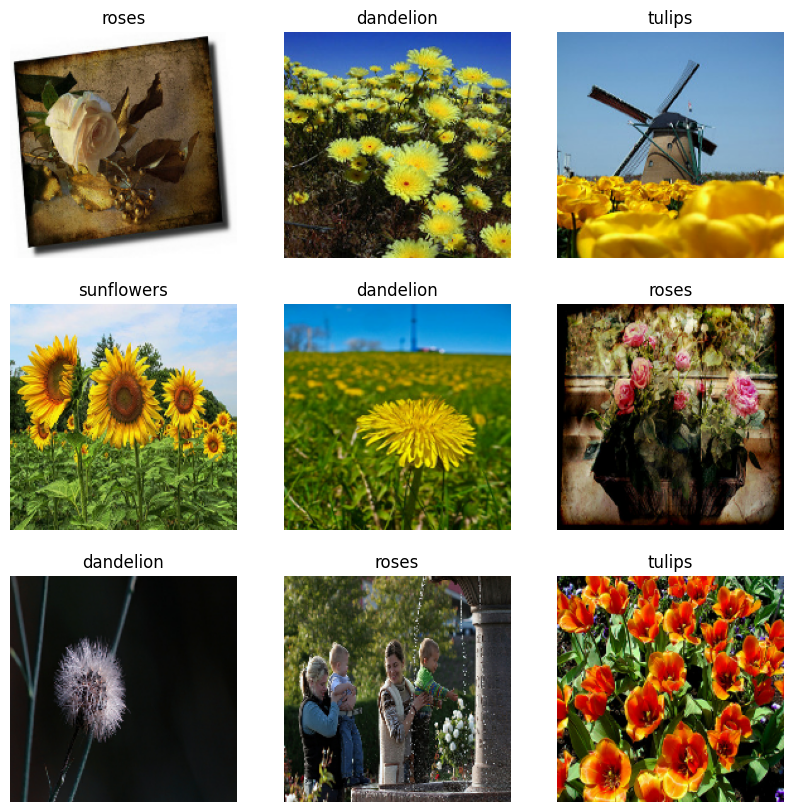

In [ ]:
#visualize 9 images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Preprocessing

Notes from tutorial: 



> **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

> **Dataset.prefetch** overlaps data preprocessing and model execution while training.




In [ ]:
#prefetch and cache
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the Model

In [ ]:
num_classes = len(class_names)

#create model
model = Sequential([
    #rescale from 0-255 to 0-1
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), #3 for RGB

    #1st convultional layer: 16 filters, 3 is the kernel_size (3x3 conv. window), even zeroes padding ('same')
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    #max-pooling layer
    layers.MaxPooling2D(),
    #2nd conv. layer: 32 filters, 3x3 window
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #3rd conv.layer: 64 filters, 3x3 window
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #convert from 2d into 1d vector
    layers.Flatten(),

    #dense layer with 128 neurons
    layers.Dense(128, activation='relu'),
    #output layer with num_classes to be sorted into
    layers.Dense(num_classes)
])

In [ ]:
#compile model
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        9

My notes on the model:

rescales to 0-1 -> outputs 16 filters -> max_pooling reduces images to half size -> *similar for other convultional layers...* -> flatten -> dense neural network for classification -> num_class outputs

In [ ]:
#train the model
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 19s 34ms/step - loss: 1.5044 - accuracy: 0.3583 - val_loss: 1.1560 - val_accuracy: 0.5354
Epoch 2/10
92/92 [==============================] - 2s 17ms/step - loss: 1.0985 - accuracy: 0.5637 - val_loss: 1.0389 - val_accuracy: 0.5749
Epoch 3/10
92/92 [==============================] - 2s 17ms/step - loss: 0.8788 - accuracy: 0.6740 - val_loss: 0.9742 - val_accuracy: 0.6063
Epoch 4/10
92/92 [==============================] - 2s 19ms/step - loss: 0.6917 - accuracy: 0.7483 - val_loss: 0.9511 - val_accuracy: 0.6226
Epoch 5/10
92/92 [==============================] - 2s 18ms/step - loss: 0.4936 - accuracy: 0.8249 - val_loss: 0.9742 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 2s 17ms/step - loss: 0.3116 - accuracy: 0.9029 - val_loss: 1.1612 - val_accuracy: 0.6417
Epoch 7/10
92/92 [==============================] - 2s 17ms/step - loss: 0.1930 - accuracy: 0.9349 - val_loss: 1.1737 - val_accuracy: 0.6144
Epoch 8/10
9

**This model faces overfitting**: 

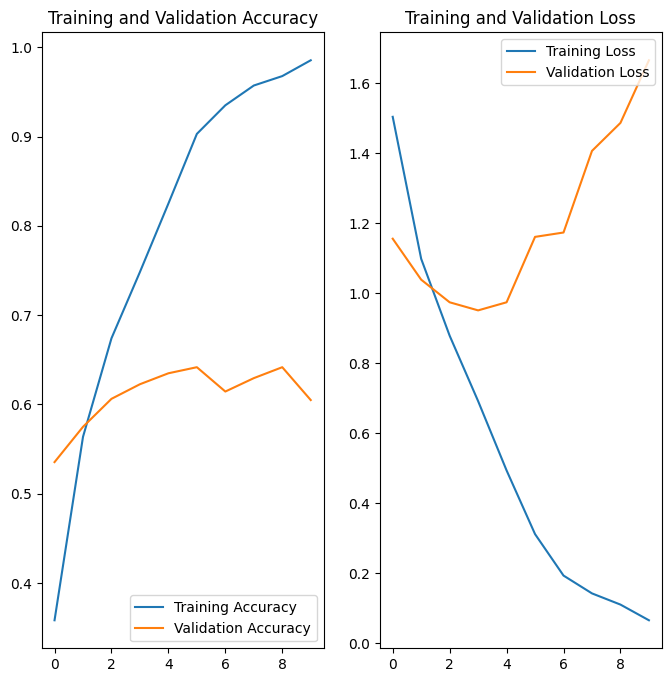

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



---


# Addressing Overfitting: Data Augmentation

**Notes**: 
* This overfitting likely stems from not having enough training examples. 
* We can use *data augmentation* 
 >  Data augmentation takes the approach of **generating additional training data from your existing examples** by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.
* 




In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

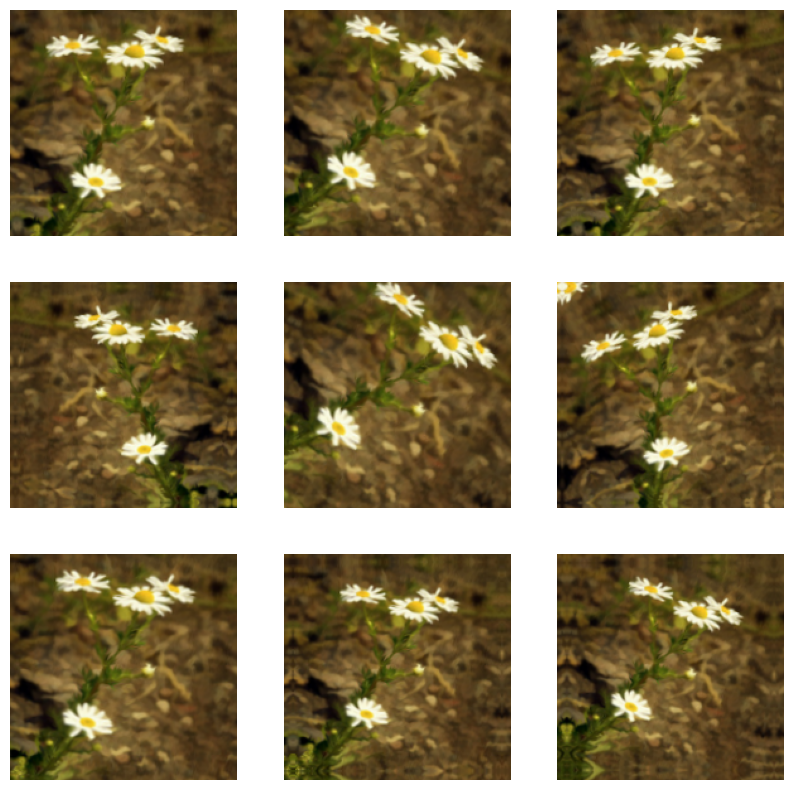

In [ ]:
#visualize the augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Addressing Overfitting: Dropout

*Notes*: 
* Can use dropout regularization to reduce overfitting
> When you apply dropout to a layer, it **randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process**. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.



---



### **New Model**: Reduced Overfitting

In [ ]:
model = Sequential([
  data_augmentation, #added data augmentation
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
  layers.Dropout(0.2),#added dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 7s 33ms/step - loss: 1.2413 - accuracy: 0.4755 - val_loss: 1.2285 - val_accuracy: 0.5259
Epoch 2/15
92/92 [==============================] - 3s 28ms/step - loss: 1.0335 - accuracy: 0.5889 - val_loss: 1.0690 - val_accuracy: 0.5913
Epoch 3/15
92/92 [==============================] - 3s 27ms/step - loss: 0.9577 - accuracy: 0.6281 - val_loss: 0.9161 - val_accuracy: 0.6553
Epoch 4/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8605 - accuracy: 0.6645 - val_loss: 0.8287 - val_accuracy: 0.6853
Epoch 5/15
92/92 [==============================] - 3s 29ms/step - loss: 0.7908 - accuracy: 0.6941 - val_loss: 0.9371 - val_accuracy: 0.6471
Epoch 6/15
92/92 [==============================] - 3s 28ms/step - loss: 0.7684 - accuracy: 0.7112 - val_loss: 0.8071 - val_accuracy: 0.6730
Epoch 7/15
92/92 [==============================] - 3s 27ms/step - loss: 0.7400 - accuracy: 0.7166 - val_loss: 0.7586 - val_accuracy: 0.6975
Epoch 8/15
92

**This model is less accurate, but it faces less overfitting:**

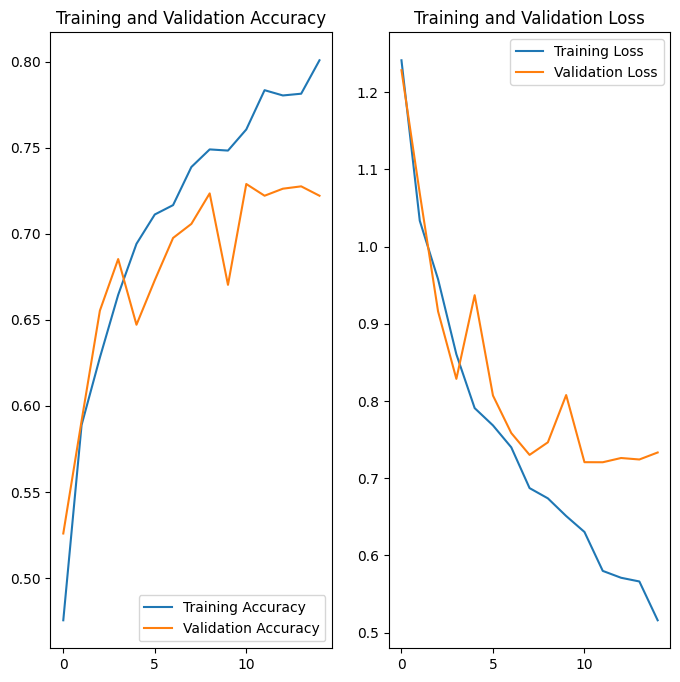

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on New Data

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 772ms/step
This image most likely belongs to sunflowers with a 92.32 percent confidence.


**Trying to predict with my own random image I found:** 

In [ ]:
tulips_url = "https://images.unsplash.com/photo-1586968295564-92fd7572718b?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=2670&q=80"
tulips_path = tf.keras.utils.get_file('photo-1586968295564-92fd7572718b', origin=tulips_url)

img = tf.keras.utils.load_img(
    tulips_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 31ms/step
This image most likely belongs to tulips with a 99.54 percent confidence.


It works!